# 目标
- 学习直方图的反向投影。

# 1. 理论
直方图的反向投影是由**Michael J. Swain , Dana H. Ballard**在他们的论文*‘Indexing via color histograms’*中提出的。

**简单地说，什么是直方图反向投影？**  
该技术用于图像分割或在图像中寻找感兴趣的目标。简单的说，该操作创建一幅与输入图像同样大小的图像，每一个像素所存储的是该像素属于目标的概率。更简单的说，在输出图像中目标会比其他区域更亮。这就是直方图反向投影的直觉解释，该技术被用于连续自适应均值移动（CamShift）算法中。

**如何去做？**  
首先创建一个包含目标图像（例如下面的例子中是地面，我们要去除运动员和其他的图像内容）的直方图，图像中目标尽可能的充满图像会有更好的结果。推荐使用颜色直方图，而不是灰度直方图，这是因为颜色直方图能够比灰度直方图更好的定义目标。当需要寻找该目标时，将该直方图**反向投影**到测试图像上。计算每一个像素属于该直方图的概率并显示它。对结果进行适当的阈值操作以获得地面区域。

# 2. 基于Numpy的算法实现
- 首先计算目标图像和待搜索图像的颜色直方图，用M表示目标图像的直方图，用I表示搜索图像的直方图。

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# roi是需要寻找的目标
roi = cv2.imread('../data/messi5_hist_backproj.jpg')
hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# target是要搜索的图像
target = cv2.imread('../data/messi5.jpg')
hsvt = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)

# 用calcHist计算二维直方图，也可以用np.histogram2d来计算
M = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])
I = cv2.calcHist([hsvt], [0, 1], None, [180, 256], [0, 180, 0, 256])

- 计算比率：$R=\frac MI$ ，然后利用R来进行反向投影。建立一幅新的图像，该图像的每一个像素代表搜索图像中该像素属于目标的概率，也就是说$B(x,y)=R[h(x,y), s(x,y)]$，其中h和s是像素$(x,y)$的色调和饱和度。然后用令$B(x,y)=min[B(x,y), 1]$

In [96]:
R = M / (I + 1)
h, s, v = cv2.split(hsvt)
B = R[h.ravel(), s.ravel()]
B = np.minimum(B, 1)
B = B.reshape(hsvt.shape[:2])

- 应用圆形区域卷积$B = D * B$其中D是圆形卷积核

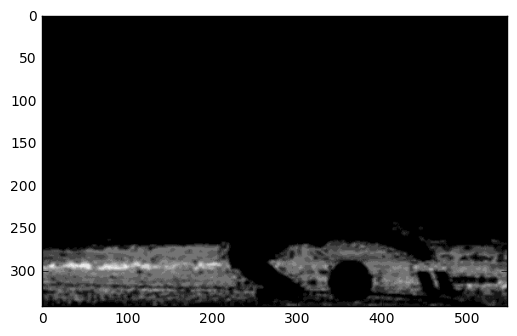

In [97]:
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.filter2D(B, -1, disc, B)
B = np.uint8(B)
cv2.normalize(B, B, 0, 255, cv2.NORM_MINMAX)
plt.imshow(B, 'gray')

- 目标区域应该有最大的亮度值，可以用阈值获得更好的结果。

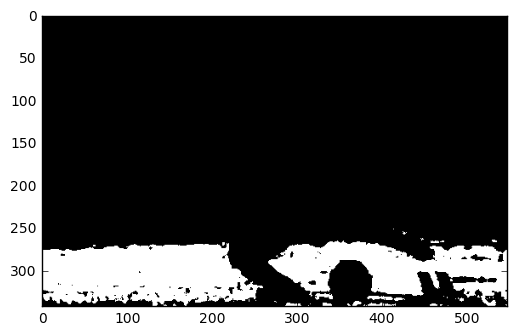

In [103]:
ret, thresh = cv2.threshold(B, 30, 255, 0)
plt.imshow(thresh, 'gray')

# 2. 基于OpenCV的算法实现
OpenCV提供了**cv2.calcBackProject()**函数，它的参数几乎与**cv2.calcHist()**相同。参数中需要一个目标图像的直方图。目标直方图在传递给反向投影函数之前，需要进行归一化。该函数返回概率图像，然后对该图像进行圆形卷积并应用阈值操作。

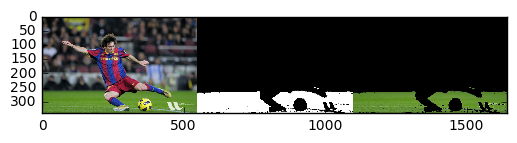

In [111]:
import numpy as np
import cv2

roi = cv2.imread('../data/messi5_hist_backproj.jpg')
hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

target = cv2.imread('../data/messi5.jpg')
hsvt = cv2.cvtColor(target, cv2.COLOR_BGR2HSV)

# 计算目标图像的直方图
roihist = cv2.calcHist([hsv], [0, 1], None, [180, 256], [0, 180, 0, 256])

# 归一化直方图，然后应用反向投影
disc = cv2.normalize(roihist, roihist, 0, 255, cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvt], [0, 1], roihist, [0, 180, 0, 256], 1)

# 用圆形卷积
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cv2.filter2D(dst, -1, disc, dst)

# 应用阈值与二进制与运算
ret, thresh = cv2.threshold(dst, 50, 255, 0)
thresh = cv2.merge((thresh, thresh, thresh))
res = cv2.bitwise_and(target, thresh)

res = np.hstack((target, thresh, res))
plt.imshow(res[:, :, ::-1])

# 3. 更多资源
1. "Indexing via color histograms", Swain, Michael J. , Third international conference on computer vision,1990.